In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import math
import copy
import pickle
from keras.models import Sequential, Model
from keras.callbacks import EarlyStopping, ModelCheckpoint

from keras.layers import BatchNormalization, Layer, TimeDistributed, Dropout
from keras.layers import Dense, Input, Masking, LSTM
from sklearn.preprocessing import MinMaxScaler, RobustScaler
from sklearn.metrics import mean_squared_error

Using TensorFlow backend.


## Data Loading and Pre-Processing

Let's start by trying to load in our toy jets, and then separate into features (to train on) and labels (to predict).

For features, first try d0, z0, phi, theta, qOverP, (refPx, refPy, refPz)?. Essentially the track parameters.

For labels, Xs, Ys, Zs, Xt, Yt, Zt. That is the secondary and tertiary vertices. Omit the primary as this has been fixed to (0,0,0). This will require some smart selection for c and light jets, where not all vertices are present. If a vertex is not present, could try predicting (0,0,0) or (-1,-1,-1) or previous vertex (prim or sec).

In [50]:
bjets_DF = pd.read_pickle("./bjets_fixJetAxisPiBy4.pkl")
#cjets_DF = pd.read_pickle("./cjets.pkl")
#ljets_DF = pd.read_pickle("./ljets.pkl")

In [51]:
np.linalg.norm(np.array([bjets_DF['tracks'][0]])[:,:,5:8], axis=2) #gives a feel for ordering, lists r of ref postion

array([[0.00000000e+00, 8.37103452e-03, 1.17708156e-02, 1.17737862e-02,
        1.17373107e-02, 1.17009342e-02, 1.52302552e-05, 6.78582096e-06,
        1.22354167e-05, 1.08630882e-05, 1.38014829e-05, 6.51194847e-06,
                   nan,            nan,            nan,            nan,
                   nan,            nan,            nan,            nan,
                   nan,            nan,            nan,            nan,
                   nan,            nan,            nan,            nan,
                   nan,            nan]])

Extract the track parameters as our features

In [52]:
%%time
trks=np.zeros((len(bjets_DF), 30, 5))

for i in range(len(bjets_DF)):
    trks[i] = np.array([bjets_DF['tracks'][i]])[:,:,0:5]
    


Wall time: 11.8 s


In [53]:
X = trks # following convention name the features as the vector 'X'

### Track Ordering

Use numpy sort function should work, order in descending value say of impact parameter or something (shouldnt be any negatives)

Maybe want to move this section and order later, after normalization

In [67]:
%%time
Xordered = copy.copy(X)#
Xordered = np.nan_to_num(Xordered)

for i,jet in enumerate(Xordered[:,1:]):
    Xordered[i,1:] = jet[np.abs(jet[:,0]).argsort()[::-1]]


Wall time: 4.97 s


In [72]:
Xordered[5]

array([[ 0.00000000e+00,  0.00000000e+00,  7.85407340e-01,
         7.85402080e-01,  1.92429924e-05],
       [ 2.00022116e-03, -1.16675999e-03,  9.43066924e-01,
         6.66313834e-01,  7.17339434e-04],
       [ 1.74738381e-03,  3.25532909e-03,  7.32778516e-01,
         1.10462290e+00,  3.89469261e-04],
       [ 1.12789364e-03,  1.64433382e-03,  8.17002469e-01,
         9.77021723e-01,  4.64129800e-04],
       [ 4.02104330e-04,  4.39120457e-04,  8.00868369e-01,
         8.56897023e-01,  1.14345654e-04],
       [ 2.87020065e-04, -2.53868289e-04,  7.79234091e-01,
         7.40599277e-01,  2.69554580e-05],
       [ 1.36405868e-05,  5.91717890e-06,  7.35515071e-01,
         8.73810237e-01,  2.40695205e-03],
       [ 1.26771025e-05,  7.95574124e-06,  8.94972509e-01,
         5.61415404e-01,  5.67348721e-04],
       [ 1.23425144e-05,  1.33177882e-05,  7.48794010e-01,
         8.91283105e-01,  2.69575499e-04],
       [ 9.99259694e-06,  3.23455242e-06,  7.63384968e-01,
         7.62355230e-01

## Data Normalization

I think we want to ensure all paramters are approx unity in order not to bias the RNN towards a particular feature. phi and theta are already approx unity (order pi), but qOverP is very small order 1e-4 and IP are also small (but scale multiple orders of magnitude) 1e-6 to 1e-2 (unfortunately)

So want to use a min max scaler or RobustScaler (so we don't bias to outliers).

C:\Users\Greg\Anaconda3\lib\site-packages\numpy\lib\histograms.py:391: RuntimeWarning: invalid value encountered in greater_equal
  keep = (a >= first_edge)
C:\Users\Greg\Anaconda3\lib\site-packages\numpy\lib\histograms.py:392: RuntimeWarning: invalid value encountered in less_equal
  keep &= (a <= last_edge)
C:\Users\Greg\Anaconda3\lib\site-packages\numpy\lib\histograms.py:824: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
C:\Users\Greg\Anaconda3\lib\site-packages\numpy\lib\histograms.py:825: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


(array([1.509757e+06, 4.832700e+04, 4.842100e+04, ..., 0.000000e+00,
        0.000000e+00, 1.000000e+00]),
 array([-4.71476409e-06,  1.03558040e-05,  2.54263720e-05, ...,
         2.86896468e-02,  2.87047174e-02,  2.87197880e-02]),
 <a list of 1906 Patch objects>)

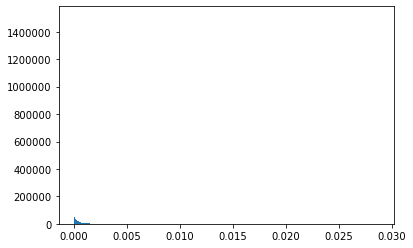

In [107]:
d0s = np.reshape(X[:,:,0],(30*len(bjets_DF)))
d0s = d0s[~(d0s == np.NaN)]
d0s
plt.hist(d0s,bins='scott') # I believe this is the array containing all the d0s

In [9]:
print(np.mean(X[:,:,0]*1e4))
print(np.mean(X[:,:,1]*1e6)) # difficult one to handle this due to large variance
print(np.mean(X[:,:,4]*1e4))
print()
print(np.std(X[:,:,0]*1e4)) # these are troublesome yes
print(np.std(X[:,:,1]*1e6))
print(np.std(X[:,:,4]*1e4))
# so we will apply the above multiples, this will bring the averages to about unity (unfortunately some outliers will
# be very large, so probs better to use a min max scaler or something but then exclude 0?)

nan
nan
nan

nan
nan
nan


Here we scale all the features to bring them to average unity, this is very simplistic so we need a better way in future

It means it works faster.

Here we instead use a min-max scaler to try and solve the problem of scale i.e. certain IPs are 10^4 times larger than others. The min-max scaler means all features will be scaled equivalently.

Here we go, minmax scaling

In [108]:
Xscaled = copy.copy(X)

In [109]:
%%time
for track_variable in range(5):
    var_to_scale = Xscaled[:,:,track_variable]
    if (track_variable == 0):
        print((track_variable == 0))
        print(track_variable)
        scaler=RobustScaler()
    elif (track_variable == 4):
        print((track_variable == 4))
        print(track_variable)
        scaler=RobustScaler()
    elif (track_variable == 1):
        print(track_variable)
        scaler = RobustScaler()
    else:
        scaler=MinMaxScaler([-1,1])
    scaler.fit(var_to_scale)
    Xscaled[:,:,track_variable] = scaler.transform(var_to_scale)

True
0


C:\Users\Greg\Anaconda3\lib\site-packages\numpy\lib\nanfunctions.py:959: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanmedian1d, axis, a, overwrite_input)
C:\Users\Greg\Anaconda3\lib\site-packages\numpy\lib\function_base.py:3405: RuntimeWarning: All-NaN slice encountered
  r = func(a, **kwargs)


1


C:\Users\Greg\Anaconda3\lib\site-packages\numpy\lib\nanfunctions.py:959: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanmedian1d, axis, a, overwrite_input)
C:\Users\Greg\Anaconda3\lib\site-packages\numpy\lib\function_base.py:3405: RuntimeWarning: All-NaN slice encountered
  r = func(a, **kwargs)
C:\Users\Greg\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:355: RuntimeWarning: All-NaN slice encountered
  data_min = np.nanmin(X, axis=0)
C:\Users\Greg\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:356: RuntimeWarning: All-NaN slice encountered
  data_max = np.nanmax(X, axis=0)
C:\Users\Greg\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:355: RuntimeWarning: All-NaN slice encountered
  data_min = np.nanmin(X, axis=0)
C:\Users\Greg\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:356: RuntimeWarning: All-NaN slice encountered
  data_max = np.nanmax(X, axis=0)


True
4


C:\Users\Greg\Anaconda3\lib\site-packages\numpy\lib\nanfunctions.py:959: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanmedian1d, axis, a, overwrite_input)
C:\Users\Greg\Anaconda3\lib\site-packages\numpy\lib\function_base.py:3405: RuntimeWarning: All-NaN slice encountered
  r = func(a, **kwargs)


Wall time: 3.55 s


In [20]:
#X

9000000


C:\Users\Greg\Anaconda3\lib\site-packages\numpy\lib\histograms.py:391: RuntimeWarning: invalid value encountered in greater_equal
  keep = (a >= first_edge)
C:\Users\Greg\Anaconda3\lib\site-packages\numpy\lib\histograms.py:392: RuntimeWarning: invalid value encountered in less_equal
  keep &= (a <= last_edge)
C:\Users\Greg\Anaconda3\lib\site-packages\numpy\lib\histograms.py:824: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
C:\Users\Greg\Anaconda3\lib\site-packages\numpy\lib\histograms.py:825: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


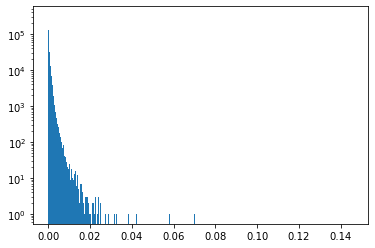

9000000


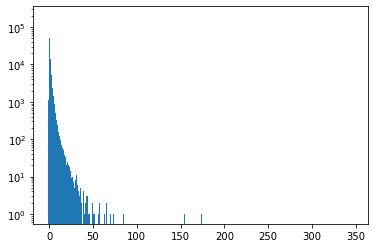

In [110]:
var=4
trackvar = X[:,:,var]
trackvar = trackvar[~(trackvar == np.NaN)]
print(len(trackvar))

plt.hist(trackvar,bins='scott',log=True)
plt.show()

trackvar2 = Xscaled[:,:,var]
trackvar2 = trackvar2[~(trackvar2 == np.NaN)]
print(len(trackvar2))


plt.hist(trackvar2,bins='scott',log=True)
plt.show()

In [111]:
Xscaled = np.nan_to_num(Xscaled)

Now we scale the outputs, actually more simple, we change units from metres to millimetres

And the secondary and tertiary vertices as our labels

In [114]:
y = bjets_DF[['secVtx_x','secVtx_y','secVtx_z','terVtx_x','terVtx_y','terVtx_z']].values 
y = y*1000 # change units of vertices from m to mm, keep vals close to unity 
# again convention call labels 'y'

Split first 80000 jets as train and next 20000 as test. Below some plots to show these jets are equivalently distributed

In [14]:
X=np.nan_to_num(X)

In [115]:
split= 280000 #int(0.9*len(bjets_DF))
X_train=Xscaled[:split]
X_test=Xscaled[split:]
y_train=y[:split]
y_test=y[split:]
print(split)

280000


In [118]:
b_s1=np.linalg.norm(bjets_DF[['secVtx_x','secVtx_y','secVtx_z']],axis=1)[:split]
b_s2=np.linalg.norm(bjets_DF[['secVtx_x','secVtx_y','secVtx_z']],axis=1)[split:]
b_t1=np.linalg.norm(bjets_DF[['terVtx_x','terVtx_y','terVtx_z']],axis=1)[:split]
b_t2=np.linalg.norm(bjets_DF[['terVtx_x','terVtx_y','terVtx_z']],axis=1)[split:]
plt.show()

0.0037009184215250172
0.007048885228276706


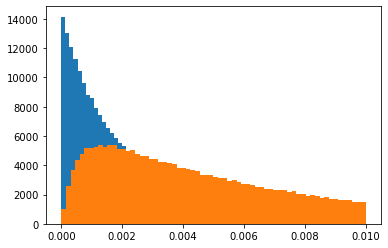

In [119]:
plt.hist(b_s1,bins='scott',range=[0,0.01])
#plt.hist(c_SecVtx,bins='scott',range=[0,0.01])
plt.hist(b_t1,bins='scott',range=[0,0.01])

print(np.mean(b_s1))
print(np.mean(b_t1))


0.0036771308144213847
0.0070087130512938856


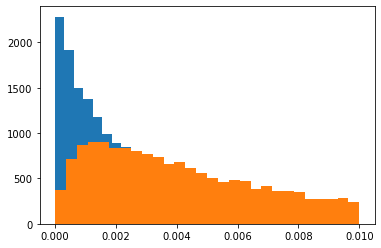

In [120]:
plt.hist(b_s2,bins='scott',range=[0,0.01])
#plt.hist(c_SecVtx,bins='scott',range=[0,0.01])
plt.hist(b_t2,bins='scott',range=[0,0.01])

print(np.mean(b_s2))
print(np.mean(b_t2))


So finally we have our features, X, and labels, y. Split into training and testing samples.

## Data Plots and Sanity Checks

Here I should have some plots on the track variables to ensure everything is logical and working fine, especially when I make changes to the data. Can potentially use seaborn...

## Constructing and Training an RNN

Here we create an RNN based on LSTM cells using keras and tensorflow. The RNN will for each jet candidate take the tracks as inputs and attempt to predict the secondary and tertiary vertex positions. Let's see how well it does.

I anticipate having to set a tolerance on the predicted values, it will never get them perfectly but we need to tell it how close it has to get for it to be considered successful.

Let's begin by creating the RNN architecture

In [44]:
# Select number of hidden and dense layers. Initially use same as RNNIP but these can be tuned going forward.

nHidden = 100
nDense = 20

In [45]:
nJets, nTrks, nFeatures = X_train.shape
nOutputs = y.shape[1] # ie sec and ter vtx xyz, so 6

In [46]:
trk_inputs = Input(shape=(nTrks,nFeatures),name="Trk_inputs")
masked_input = Masking()(trk_inputs)

# Feed this merged layer to an RNN
lstm = LSTM(nHidden, return_sequences=False, name='LSTM')(masked_input)
dpt = Dropout(rate=0.2)(lstm) # this is a very high dropout rate, reduce it

my_inputs = trk_inputs

# Fully connected layer: This will convert the output of the RNN to our vtx postion predicitons
FC = Dense(nDense, activation='relu', name="Dense")(dpt) # is relu fine here? i think so...

# Ouptut layer. Sec and Ter Vtx. No activation as this is a regression problem
output = Dense(nOutputs, name="Vertex_Predictions")(FC)

myRNN = Model(inputs=my_inputs, outputs=output)


In [47]:
myRNN.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Trk_inputs (InputLayer)      (None, 30, 5)             0         
_________________________________________________________________
masking_3 (Masking)          (None, 30, 5)             0         
_________________________________________________________________
LSTM (LSTM)                  (None, 100)               42400     
_________________________________________________________________
dropout_3 (Dropout)          (None, 100)               0         
_________________________________________________________________
Dense (Dense)                (None, 20)                2020      
_________________________________________________________________
Vertex_Predictions (Dense)   (None, 6)                 126       
Total params: 44,546
Trainable params: 44,546
Non-trainable params: 0
_________________________________________________________________


In [48]:
myRNN.compile(loss='mean_absolute_error', optimizer='adam', metrics=['mae']) # do i want to add a metric like mse to evaluate during training


 checkpoints, training, evaluation of performance
 different ways of evaluating performance obviously
 either akin to Nicole's method for RNNIP
 or the slighlty different method in https://github.com/agu3rra/NeuralNetwork-RegressionExample/blob/master/Tutorial.ipynb

In [49]:
myRNN_mChkPt = ModelCheckpoint('myRNN_weights.h5',monitor='val_loss', verbose=True,
                               save_best_only=True,
                               save_weights_only=True)

In [50]:
earlyStop = EarlyStopping(monitor='val_loss', verbose=True, patience=10)


In [51]:
nEpochs = 100

myRNN_hist = myRNN.fit(X_train, y_train, epochs=nEpochs, batch_size=256,validation_split=0.20,
                 callbacks=[earlyStop, myRNN_mChkPt],) # callbacks=[earlyStop, myRNN_mChkPt])

Train on 224000 samples, validate on 56000 samples
Epoch 1/100
224000/224000 [==============================] - 73s 324us/step - loss: 0.9767 - mean_absolute_error: 0.9767 - val_loss: 0.8014 - val_mean_absolute_error: 0.8014
Epoch 2/100
224000/224000 [==============================] - 77s 345us/step - loss: 0.7798 - mean_absolute_error: 0.7798 - val_loss: 0.7125 - val_mean_absolute_error: 0.7125
Epoch 3/100
224000/224000 [==============================] - 77s 343us/step - loss: 0.7018 - mean_absolute_error: 0.7018 - val_loss: 0.6337 - val_mean_absolute_error: 0.6337
Epoch 4/100
224000/224000 [==============================] - 76s 341us/step - loss: 0.6381 - mean_absolute_error: 0.6381 - val_loss: 0.5898 - val_mean_absolute_error: 0.5898
Epoch 5/100
224000/224000 [==============================] - 78s 348us/step - loss: 0.5966 - mean_absolute_error: 0.5966 - val_loss: 0.5517 - val_mean_absolute_error: 0.5517
Epoch 6/100
224000/224000 [==============================] - 76s 338us/step - l

Epoch 24/100
224000/224000 [==============================] - 73s 326us/step - loss: 0.3531 - mean_absolute_error: 0.3531 - val_loss: 0.3371 - val_mean_absolute_error: 0.3371
Epoch 25/100
224000/224000 [==============================] - 72s 322us/step - loss: 0.3450 - mean_absolute_error: 0.3450 - val_loss: 0.3126 - val_mean_absolute_error: 0.3126
Epoch 26/100
224000/224000 [==============================] - 73s 326us/step - loss: 0.3395 - mean_absolute_error: 0.3395 - val_loss: 0.3141 - val_mean_absolute_error: 0.3141
Epoch 27/100
224000/224000 [==============================] - 73s 327us/step - loss: 0.3335 - mean_absolute_error: 0.3335 - val_loss: 0.3123 - val_mean_absolute_error: 0.3123
Epoch 28/100
224000/224000 [==============================] - 73s 327us/step - loss: 0.3267 - mean_absolute_error: 0.3267 - val_loss: 0.3023 - val_mean_absolute_error: 0.3023
Epoch 29/100
224000/224000 [==============================] - 73s 328us/step - loss: 0.3206 - mean_absolute_error: 0.3206 - v

224000/224000 [==============================] - 75s 334us/step - loss: 0.2147 - mean_absolute_error: 0.2147 - val_loss: 0.2091 - val_mean_absolute_error: 0.2091
Epoch 74/100
224000/224000 [==============================] - 76s 337us/step - loss: 0.2144 - mean_absolute_error: 0.2144 - val_loss: 0.2177 - val_mean_absolute_error: 0.2177
Epoch 75/100
224000/224000 [==============================] - 75s 334us/step - loss: 0.2124 - mean_absolute_error: 0.2124 - val_loss: 0.2113 - val_mean_absolute_error: 0.2113
Epoch 00075: early stopping


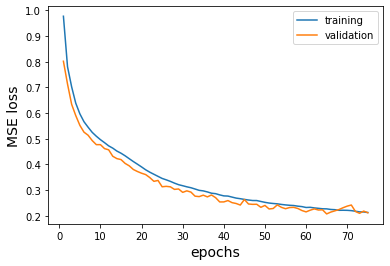

In [52]:
epochs = np.arange(1,len(myRNN_hist.history['loss'])+1)

plt.plot(epochs,myRNN_hist.history['loss'],label='training')
plt.plot(epochs,myRNN_hist.history['val_loss'],label='validation')
plt.xlabel('epochs',fontsize=14)
plt.ylabel('MSE loss',fontsize=14)
plt.legend()

In [121]:
results=myRNN.predict(X_test)
results

array([[ 6.035548  ,  6.035423  ,  8.529224  ,  7.9623833 ,  7.9528184 ,
        11.439747  ],
       [ 1.2154033 ,  1.2163118 ,  1.7182101 ,  2.549752  ,  2.5492399 ,
         3.6417458 ],
       [ 1.8820744 ,  1.8781972 ,  2.646237  ,  7.1155863 ,  7.093253  ,
        10.145479  ],
       ...,
       [ 0.9552002 ,  0.95508045,  1.347066  ,  2.1287427 ,  2.1214528 ,
         2.7906845 ],
       [ 0.18647021,  0.18860167,  0.26824802,  0.66900545,  0.67024285,
         0.842746  ],
       [ 3.289676  ,  3.2817354 ,  4.624417  , 10.769046  , 10.730526  ,
        15.4407    ]], dtype=float32)

In [122]:
len(results)

20000

In [123]:
percentage_errs=(abs((results-y_test)/y_test)*100) # average error of 50%, so for vtx at 1mm, we get within 0.5mm


In [22]:
# load model
#myRNN.load_weights('./myRNN_weights.h5')


(array([45943., 32116., 16180.,  8490.,  4722.,  2776.,  1858.,  1297.,
          897.,   669.,   551.,   419.,   345.,   257.,   235.,   201.,
         2765.]),
 array([   0,    5,   10,   15,   20,   25,   30,   35,   40,   45,   50,
          55,   60,   65,   70,   75,   80, 1000]),
 <a list of 17 Patch objects>)

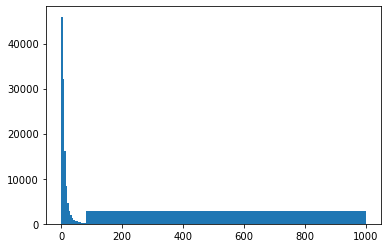

In [124]:
meanerrs=percentage_errs.reshape(120000)# plot distribution of mean errs per jet

plt.hist((meanerrs), bins=[0,5,10,15,20,25,30,35,40,45,50,55,60,65,70,75,80,1000])#90,100,200,300,400,500,600,700,800,900])
#plt.hist((meanerrs), bins=[0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9])

# from what i see, the profile drops off but with a VERY long tail
# about 65000/120000 vals less than 15% error (so more than half)
# but 10000 have over 80% error (1/12)
# problem also, for a jet we might nail down the x values very well but do badly with the z or y

# without badphis and thetas, approx 3/4 below 15% 
# approx 1/20 above 80%

# switching to seperate errs for IP, over 3/4 below 15% (96000/120000)
# 1/40 above

In [125]:
mean_err_per_jet=np.mean(percentage_errs,axis=1)

In [126]:
print(np.median(mean_err_per_jet)) # median error is 7% that's actually not too bad considering gauss err of 1% on 5 params (ish)
np.mean(mean_err_per_jet) # mean and median very different

7.691437301563781


33.282745108060006

couple of things, first the RNN looks like it predicts the same value for all cases. This might be because it uses the null tracks at the end of every single jet and just predicts off of those.
Maybe should consider predicting values that are at least order unity, because mse is gonna be very small otherwise, so convert the vertices into different units (I dunno maybe millimeters or microns)

In [127]:
len(mean_err_per_jet[mean_err_per_jet > 100.]) # 1970/20,000 jets mean err above 100% dropd to 907/20,000

486

In [128]:
badjets=np.where(mean_err_per_jet > 100.)
badjets

(array([    5,    38,   143,   149,   195,   206,   236,   240,   251,
          279,   381,   409,   445,   449,   461,   576,   590,   608,
          673,   719,   744,   771,   793,   899,   926,   929,   936,
          970,   981,   995,  1034,  1055,  1086,  1127,  1258,  1263,
         1286,  1348,  1474,  1478,  1501,  1511,  1516,  1519,  1525,
         1559,  1613,  1630,  1640,  1690,  1734,  1745,  1795,  1798,
         1815,  1853,  1854,  1882,  1989,  2030,  2079,  2096,  2122,
         2218,  2331,  2365,  2367,  2377,  2378,  2384,  2413,  2434,
         2484,  2565,  2629,  2645,  2786,  2808,  2822,  2835,  2857,
         2926,  2946,  2957,  2959,  2974,  2980,  2987,  2988,  2996,
         2998,  3028,  3071,  3178,  3216,  3224,  3303,  3375,  3477,
         3513,  3544,  3619,  3623,  3659,  3661,  3680,  3696,  3697,
         3722,  3738,  3742,  3746,  3928,  3937,  3987,  3990,  4075,
         4085,  4105,  4254,  4279,  4281,  4309,  4368,  4406,  4538,
      

In [74]:
#plt.hist(mean_err_per_jet[badjets],bins='scott')

In [97]:
jet=198

In [98]:
mean_err_per_jet[jet]

735.0237680616142

In [99]:
y_test[jet]

array([0.00257813, 0.00257813, 0.00364602, 0.49234786, 0.3303915 ,
       0.74276582])

In [100]:
results[jet]

array([0.0364235 , 0.04053366, 0.06108767, 0.43210566, 0.43942747,
       0.7097888 ], dtype=float32)

In [101]:
bjets_DF.iloc[280000+jet]['tracks']

[[0.0,
  0.0,
  0.7853867295557591,
  0.7854047901174959,
  0.00010714892553958463,
  0.0,
  0.0,
  0.0],
 [2.8149073836295616e-06,
  1.6806762819724374e-07,
  1.6629304676313204,
  0.6354896566393341,
  0.0015174645326652314,
  2.6052849136495596e-06,
  2.5849095801839074e-06,
  3.6923419673866943e-06],
 [2.050861353011359e-06,
  4.224432757985731e-06,
  1.2801707186704805,
  1.8273312237871129,
  0.0006365367422732366,
  2.590907769114507e-06,
  2.5853559742709803e-06,
  3.665582783597552e-06],
 [0.0003270446116875847,
  0.00023753313905532932,
  1.090291734244463,
  0.9442686319862331,
  0.0009623637475833415,
  0.0004925421857611689,
  0.0003264654486746935,
  0.000745443825903089],
 [0.00025701144032752154,
  -6.11594052961886e-05,
  0.19057256978585643,
  0.49601014325002785,
  0.0005647055449009436,
  0.0004929006424495165,
  0.00033307374518687046,
  0.0007566492461165023],
 [0.0001455125128993599,
  0.00017511524921287987,
  0.5174361882102811,
  0.91076482242922,
  0.00078568

In [162]:
indices=280000+np.where(mean_err_per_jet > 100.)[0]
bad_phis=[]
bad_thetas=[]
bad_1OverP=[]
bad_sectrkphis=[]
bad_nSecTrks=[]
bad_nTerTrks=[]

bad_sumSecTerTrks=[]

for index in indices:
    # extracts all the phi values of worst performing jets
    bad_phis.append(abs(bjets_DF.iloc[index]['tracks'][0][2]))
    bad_thetas.append(abs(bjets_DF.iloc[index]['tracks'][0][3]))
    bad_1OverP.append(abs(bjets_DF.iloc[index]['tracks'][0][4]))
    bad_sectrkphis.append(abs(bjets_DF.iloc[index]['tracks'][1][3]))
    bad_nSecTrks.append(bjets_DF.iloc[index]['nSecTracks'])
    bad_nTerTrks.append(bjets_DF.iloc[index]['nTerTracks'])

    bad_sumSecTerTrks.append(bjets_DF.iloc[index]['nSecTracks'] + bjets_DF.iloc[index]['nTerTracks'])


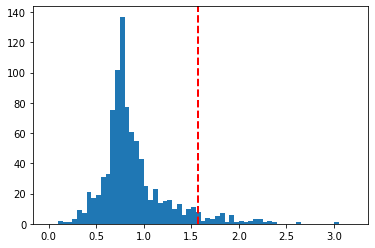

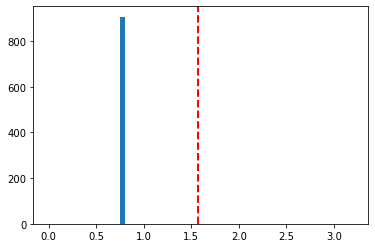

In [61]:
plt.hist(bad_sectrkphis,bins=np.linspace(0.,3.2,65))
plt.axvline(x=np.pi/2, color='r', linestyle='dashed', linewidth=2)
plt.show()

plt.hist(bad_thetas,bins=np.linspace(0.,3.2,65))
plt.axvline(x=np.pi/2, color='r', linestyle='dashed', linewidth=2)


(array([286., 128.,  95.,  75.,  71.,  50.,  52.,  53.,  37.,  32.,  28.]),
 array([ 5976.14207369, 12715.64852691, 19455.15498012, 26194.66143334,
        32934.16788656, 39673.67433977, 46413.18079299, 53152.6872462 ,
        59892.19369942, 66631.70015264, 73371.20660585, 80110.71305907]),
 <a list of 11 Patch objects>)

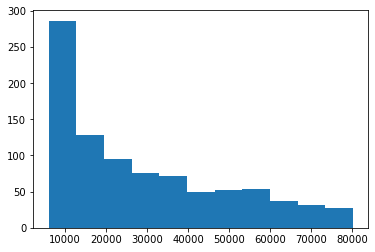

In [46]:
#plt.hist(bad_1OverP,bins=np.linspace(0.,3.2,65))
bad_ps=np.reciprocal(bad_1OverP)
plt.hist(bad_ps,bins='scott')


(array([225., 134., 127.]), array([1, 2, 3, 4]), <a list of 3 Patch objects>)

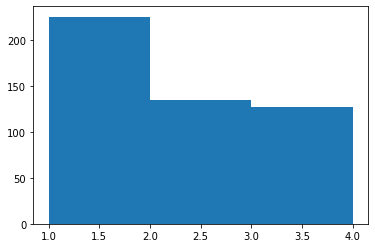

In [178]:
plt.hist(bad_nSecTrks, bins=[1,2,3,4])


(array([ 99748., 100135., 100117.]),
 array([1, 2, 3, 4]),
 <a list of 3 Patch objects>)

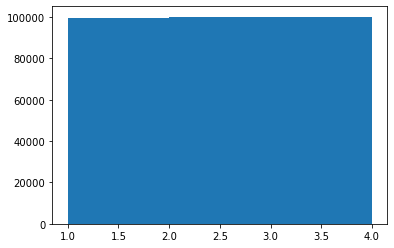

In [134]:
plt.hist(bjets_DF['nSecTracks'], bins=[1,2,3,4])

(array([148., 167., 171.]), array([2, 3, 4, 5]), <a list of 3 Patch objects>)

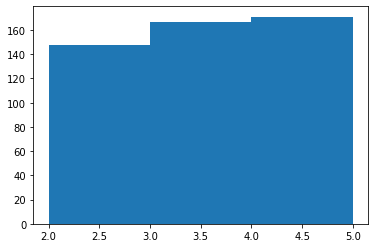

In [167]:
plt.hist(bad_nTerTrks, bins=[2,3,4,5])
plt.show()
#plt.hist(bjets_DF['nTerTracks'], bins=[2,3,4,5])

In [148]:
np.linspace(0.,3.2,17)

array([0. , 0.2, 0.4, 0.6, 0.8, 1. , 1.2, 1.4, 1.6, 1.8, 2. , 2.2, 2.4,
       2.6, 2.8, 3. , 3.2])

In [ ]:
# so in 41, we actually only had one track from the secondary vertex, three from the tertiary
# could this be fixed wih some sort of track ordering
# perhaps the RNN expects secondarys before tertiarys
# so it gets thrown when the number of sec and ter tracks is different.

# in 51, the jet_phi was very close to -pi/2, this undoubtedly could lead to large errs

In [81]:
d0,z0,phi0,theta0,qoverp=1.3081643989711976e-05,-6.615451638936065e-06,-0.6557717081719833,1.800121842067036,5.373777313714585e-05

jetphi,jettheta = -0.7666502947479463,1.8519400411980116

x0=d0*np.cos(phi0)
y0=d0*np.sin(phi0)
trk_PoCA=[x0,y0,z0]
dirvec=[100*np.sin(theta0)*np.cos(phi0), 100*np.sin(theta0)*np.sin(phi0), 100*np.cos(theta0)]
trk_secondp=[0.,0.,0.]
for i in range(len(trk_PoCA)):
    trk_secondp[i]=PoCA[i]+dirvec[i]

jetdir = [100*np.sin(jettheta)*np.cos(jetphi), 100*np.sin(jettheta)*np.sin(jetphi), 100*np.cos(jettheta)]

In [82]:
from mathutils.geometry import intersect_line_line

In [83]:
print(intersect_line_line(trk_PoCA,trk_secondp,[0,0,0],jetdir))

(Vector((9.374803994433023e-06, -7.2125230872188695e-06, -6.322869012365118e-06)), Vector((9.028971362567972e-06, -8.696616532688495e-06, -3.620333473008941e-06)))


In [80]:
print(trk_PoCA,"\n",trk_secondp,"\n",[0,0,0],"\n",jetdir)

[1.0368217982231362e-05, -7.976807967257435e-06, -6.615451638936065e-06] 
 [0.771838238659556, -0.5938151977634709, -0.22732736406629356] 
 [0, 0, 0] 
 [0.6919610134810684, -0.666489968622366, -0.277454640523474]
